<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_proj_1_EntropyComplexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Использование классификации с помощью разделения на плоскости Энтропия сложность

Знакомство с данными

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
import tqdm
!pip install ordpy
import ordpy

In [3]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'

# Знакомство с данными

In [4]:
data, samplerate = sf.read("/content/drive/MyDrive/mldm21_project/test/000316da7.flac")

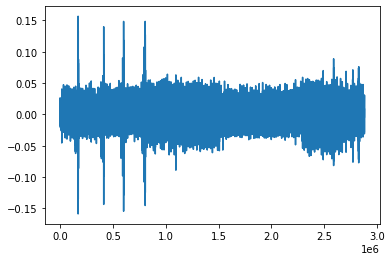

In [5]:
plt.plot(data)

In [6]:
len(data)/samplerate

60.0

Text(0.5, 0, 'Time [sec]')

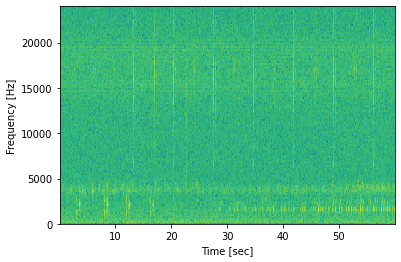

In [7]:
freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
plt.figure()
plt.pcolormesh(time, freq, np.log(Sxx))

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [8]:
dT = 0.1
len_record = len(data)
num_steps = int(samplerate*dT)
f_spectrogram = [np.abs(np.fft.fft(data[samplerate*i:samplerate*i+num_steps])) for i in np.arange(0,5)]

In [ ]:
for idata in f_spectrogram:
  plt.figure()
  plt.plot(idata)

In [11]:
data_pd = pd.read_csv('/content/drive/MyDrive/mldm21_project/train_fp.csv')

In [16]:
data_pd.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984


In [24]:
data_pd.groupby(['recording_id']).count()

,species_id,songtype_id,t_min,f_min,t_max,f_max
recording_id,,,,,,
00204008d,3,3,3,3,3,3
003b04435,2,2,2,2,2,2
005f1f9a5,1,1,1,1,1,1
0072f0839,1,1,1,1,1,1
0079ff47b,6,6,6,6,6,6
...,...,...,...,...,...,...
ffc6031f8,2,2,2,2,2,2
ffd88cd84,4,4,4,4,4,4
ffebe7313,1,1,1,1,1,1


In [25]:
data_pd[data_pd['recording_id']=='00204008d']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.25,14.9333,4125.00
1,00204008d,8,1,24.4960,3750.00,28.6187,5531.25
2,00204008d,4,1,15.0027,2343.75,16.8587,4218.75


# Обработка Данных

### Функции

In [14]:
def loadPath_ID(Path_to_folder='/content/drive/MyDrive/mldm21_project/train/', 
                path_to_label_file='/content/drive/MyDrive/mldm21_project/train_fp.csv'):
  path_to_files = []
  id = []
  for ipath,_,ifiles in os.walk(Path_to_folder):
    for ifile in ifiles:
      id.append(ifile.split('.')[0])
      path_to_files.append(ipath+ifile)
  pd_data = pd.read_csv(path_to_label_file)

  return path_to_files, id, pd_data

def crtCutVoiceData(paths_to_files,pd_data):
  label_arr = []
  data_arr = []
  for ipath_to_file in tqdm.tqdm(paths_to_files):
    data, samplerate = sf.read(ipath_to_file)
    id = ipath_to_file.split('/')[-1].split('.')[0]
    data_pd_cut = pd_data[pd_data['recording_id']==id] \
    [['species_id', 'songtype_id',	't_min', 't_max']].values
    if len(data_pd_cut)>0:
      for iline in data_pd_cut:
        label = str(int(iline[0]))+'_'+str(int(iline[1]))
        data_cut = data[int(iline[2]*samplerate):int(iline[3]*samplerate)].copy()
        label_arr.append(label)
        data_arr.append(data_cut)
  return data_arr,label_arr

In [15]:
 path_to_files, id, pd_data = loadPath_ID()
 path_to_files_cut = np.random.choice(path_to_files,size=10)
 data_arr,label_arr = crtCutVoiceData(path_to_files_cut,pd_data)

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


In [5]:


def z_prt(data,dim_z=10):
    """
    create z-vectors
    """
    length = len(data)
    num_z = length - dim_z
    z_data = [data[ind:ind+dim_z] for ind in range(num_z)]
    return np.array(z_data).copy()

def entro_vectors(z_vectors):
    i_fst = z_vectors[1:,:]
    i_sec = z_vectors[:-1,:]
    new_vectors = np.array(i_fst>i_sec,dtype=int)
    return new_vectors

def entropy(data,z_dim=10,FlagF=True):
    max_min_arr = []
    z_vects = z_prt(data,dim_z=z_dim)
    int_vectors = entro_vectors(z_vects)
    uniq_vectors,counts = np.unique(int_vectors,axis=0, return_counts=True)
    prob_arr = counts/counts.sum()
    num_val = 2**(z_dim) if FlagF else len(counts)
    H = -np.multiply(np.log(prob_arr),prob_arr).sum()/np.log(num_val)
    return H, prob_arr


def cmp_enpy(data,z_dim=10, dbFlag=False):

    entropy_n1, prob_dist = entropy(data,z_dim=z_dim)
    cell = 2**(z_dim)

    prob_uni = np.ones(cell)*(1/cell)
    assert np.sum(prob_uni) == 1, 'value {:}'.format(prob_uni)
    prob_mix = (np.pad(prob_dist,(0,len(prob_uni)-len(prob_dist))) + prob_uni)/2
   

    entropy_1 = -(prob_dist*np.log(prob_dist)).sum()
    entropy_2 = np.log(cell)
    entropy_3 = -(prob_mix*np.log(prob_mix)).sum()
    C_norm = 2*np.log(2*cell)-((cell+1)/cell)*np.log(cell+1)-np.log(cell)         #np.log(cell)
    Complexity = entropy_n1*(2*entropy_3-entropy_2-entropy_1)/C_norm
    if dbFlag:
      return entropy_n1, Complexity
    return Complexity

In [67]:
un, cnt = np.unique(label_arr,return_counts=True)

In [22]:
ordpy_dim = 5
HC = [ordpy.complexity_entropy(series, dx=ordpy_dim) for series in tqdm.tqdm(data_arr)]
#ordpy.complexity_entropy(data_arr[0], dx=5)

100%|██████████| 167/167 [03:27<00:00,  1.24s/it]


In [24]:
ar_HC = np.array(HC)
ar_lb = np.array(label_arr)

In [47]:
colors = [int((float(i.split('_')[0])*3)) for i in ar_lb]
result_pd_df = pd.DataFrame(
    {'label':ar_lb,
     'H': ar_HC[:,0],
     'C': ar_HC[:,1],
     'color':colors}
)

In [48]:
result_pd_df

,label,H,C,color
0,23_1,0.994511,0.009632,69
1,3_1,0.973296,0.045148,9
2,7_1,0.978288,0.036831,21
3,4_1,0.985620,0.024965,12
4,5_1,0.962860,0.061708,15
...,...,...,...,...
162,13_1,0.506109,0.303163,39
163,6_1,0.993519,0.011161,18
164,8_1,0.529136,0.322772,24
165,23_4,0.531153,0.316024,69


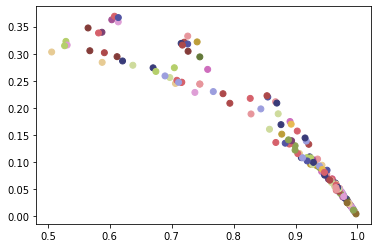

In [50]:
plt.scatter(result_pd_df['H'],result_pd_df['C'],c=result_pd_df['color'].values,cmap='tab20b')